In [1]:
import scipy.linalg as la
from scipy.special import factorial
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import numpy as np
from helper_functions.grape_functions import *
from main_grape.Grape import Grape
%pylab inline



Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def coherent_state(beta):
    coeffs = []
    pre_factor = np.exp((-(np.abs(beta))**2)/2)
    for ii in range(mode_state_num):
        coeff = pre_factor * beta**ii /(np.sqrt(factorial(ii)))
        coeffs.append(coeff)
    return coeffs

state_transfer = False
#Defining time scales
total_time = 100.0
steps = 14000

#Defining H0
qubit_state_num = 4

alpha = 0.224574
freq_ge = 3.5#GHz
ens = np.array([ 2*np.pi*ii*(freq_ge - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(np.arange(0,qubit_state_num))
I_q = np.identity(qubit_state_num)
H_q = np.diag(ens)

mode_state_num = 25
qm_g =2*np.pi*0.1
mode_freq = 4.0 #GHz
mode_ens = np.array([ 2*np.pi*ii*(mode_freq) for ii in np.arange(mode_state_num)])
M_x = np.diag(np.sqrt(np.arange(1,mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,mode_state_num)),-1)
M_y = (0+1j) *(np.diag(np.sqrt(np.arange(1,mode_state_num)),1)-np.diag(np.sqrt(np.arange(1,mode_state_num)),-1))
M_z   = np.diag(np.arange(0,mode_state_num))
H_m = np.diag(mode_ens)
I_m = np.identity(mode_state_num)

H0 = np.kron(H_q,I_m) + np.kron(I_q,H_m) +\
        + qm_g*np.kron(Q_x,M_x) 
XI = np.kron(Q_x,I_m)
YI = np.kron(Q_y,I_m)
ZI = np.kron(Q_z,I_m)
IX = np.kron(I_q,M_x)
IY = np.kron(I_q,M_y)
IZ = np.kron(I_q,M_z)

#Defining the coherent state
beta = 3.0
coeffs_1 = coherent_state(beta)
coeffs_2 = coherent_state(- beta)
coeffs_3 = coherent_state((0+1j)*beta)
cat_coeffs = (1/np.sqrt(2)) * np.add(coeffs_1,coeffs_2)
#cat_coeffs = coeffs_2

cat= cat_coeffs
cat=np.append(cat,np.zeros((qubit_state_num-1)*mode_state_num))
print cat

a=0
for k in cat:
    a = a+ np.abs(k)**2
print a



w_c, v_c = la.eig(H0)
dressed=[]
D= True
if D:
    for ii in range (len(v_c)):
        index=np.argmax(np.abs(v_c[:,ii]))
        if index not in dressed:
            dressed.append(index)
        else:
            temp= (np.abs(v_c[:,ii])).tolist()
            while index in dressed:

                temp.remove(max(temp))
                index2= np.argmax(np.array(temp))

                if index2<index:
                            #dressed.append(index2)
                    index=index2
                else:
                            #dressed.append(index2-1)
                    index=index2+1
            dressed.append(index)


#Defining states to include in the drawing of occupation
states_draw_list = range(mode_state_num)
states_draw_names = []
for ii in range (mode_state_num):
    states_draw_names.append('0_'+str(ii))

from helper_functions.grape_functions import get_state_index
g0 = v_c[:,get_state_index(0,dressed)]
if not state_transfer:
    
    if D:
        cat_d = np.zeros(mode_state_num*qubit_state_num)
    
        for ii in range(len(cat)):
            cat_d = cat_d + cat[ii] * v_c[:,get_state_index(ii,dressed)]
    else:
        cat_d = cat
   
    print "cat_d inner product: " + str(np.inner(cat_d,cat_d))
    print "g0 inner product: " + str(np.inner(g0,g0))
    U =  np.outer(cat_d,g0)
#Defining Concerned states (starting states)
else:
    U = cat
psi0=[0]

#Defining states to include in the drawing of occupation
states_draw_list = range(mode_state_num)
states_draw_names = []
for ii in range (mode_state_num):
    states_draw_names.append('g_'+str(ii))


multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              'f':freq_ge, 'es':w_c, 'g1':qm_g, 'D':D, 'Interpolation':False, 'Modulation':False}
#Defining control Hs

Hops = [XI,ZI]
Hnames =['xi','zi']

#Defining convergence parameters
max_iterations = 3000
decay = max_iterations/2
convergence = {'rate':0.05, 'update_step':10, 'max_iterations':max_iterations,\
               'conv_target':1e-3,'learning_rate_decay':decay}
penalty_coeffs = {'envelope' : 0.0, 'dc':0, 'dwdt':0.0001,'d2wdt2':0, 'forbidden':10}
#u0 = 1.001*np.load('data/cat-3-xi-zi total_time: 50.0, steps: 2000, size: 100_uks_initial_guess.npy')
#u=[]
#for ii in range(len(u0)):
    #u.append(np.interp(np.linspace(0,total_time,steps),np.linspace(0,total_time,700),u0[ii]))
#u0 =u
#u0 = 4*np.ones([2,steps])
#print dressed
#print np.shape(u0)
#u0 = np.reshape(u0,[2,2000])

forbidden = []

for ii in range(mode_state_num):
    forbid_state = (qubit_state_num-1)*mode_state_num+ii
    if not forbid_state in forbidden:
        forbidden.append(forbid_state)
        
for ii in range(qubit_state_num):
    forbid_state = ii*mode_state_num + (mode_state_num-1)
    if not forbid_state in forbidden:
        forbidden.append(forbid_state)
        
print forbidden

[ 0.01571049  0.          0.09998097  0.          0.25975818  0.
  0.42682624  0.          0.5133335   0.          0.48699092  0.
  0.38148407  0.          0.25449732  0.          0.14784958  0.
  0.07606798  0.          0.03511985  0.          0.01470531  0.          0.0056331
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.

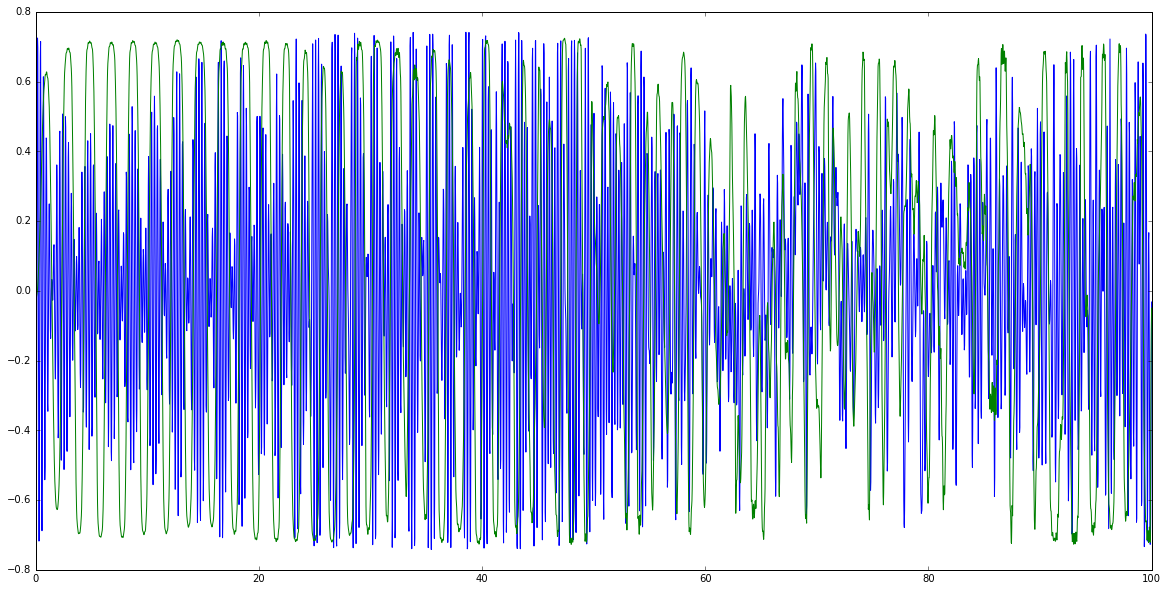

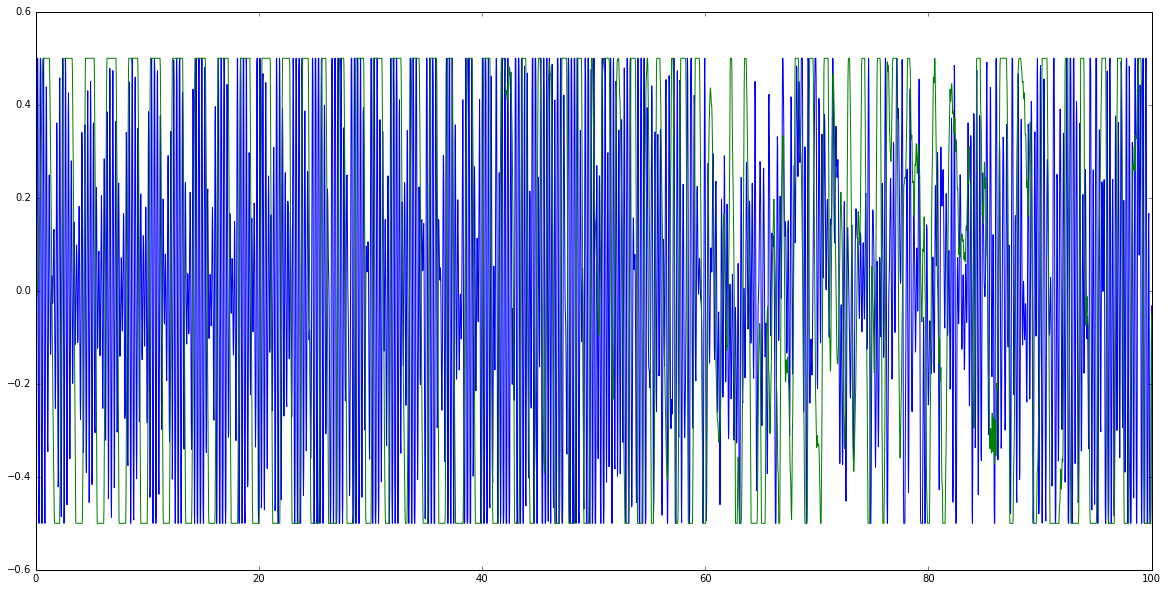

In [3]:
u0 = 1.00*np.load('data/cat-3-xi-zi-forbid-r4 total_time: 100.0, steps: 4000, size: 100_iter: 520_uks-Copy1.npy')
figure(figsize=(20,10))
plot(np.linspace(0,100,4000),u0[0])
plot(np.linspace(0,100,4000),u0[1])

new_u0 = np.clip(u0,-0.5,0.5)

figure(figsize=(20,10))
plot(np.linspace(0,100,4000),new_u0[0])
plot(np.linspace(0,100,4000),new_u0[1])

# new_u0_x = np.interp(np.linspace(100./4000,100,4000),np.linspace(50+50./2000,100,2000),u0[0],right=0,left=0)
# new_u0_z = np.interp(np.linspace(100./4000,100,4000),np.linspace(50+50./2000,100,2000),u0[1],right=0,left=0)
# figure(figsize=(20,10))
# plot(np.linspace(0,100,4000),new_u0_x)
# plot(np.linspace(0,100,4000),new_u0_z)

# new_u0 = np.zeros([2,4000])
# new_u0[0] = new_u0_x
# new_u0[1] = new_u0_z

# new_u0.shape

(2, 14000)

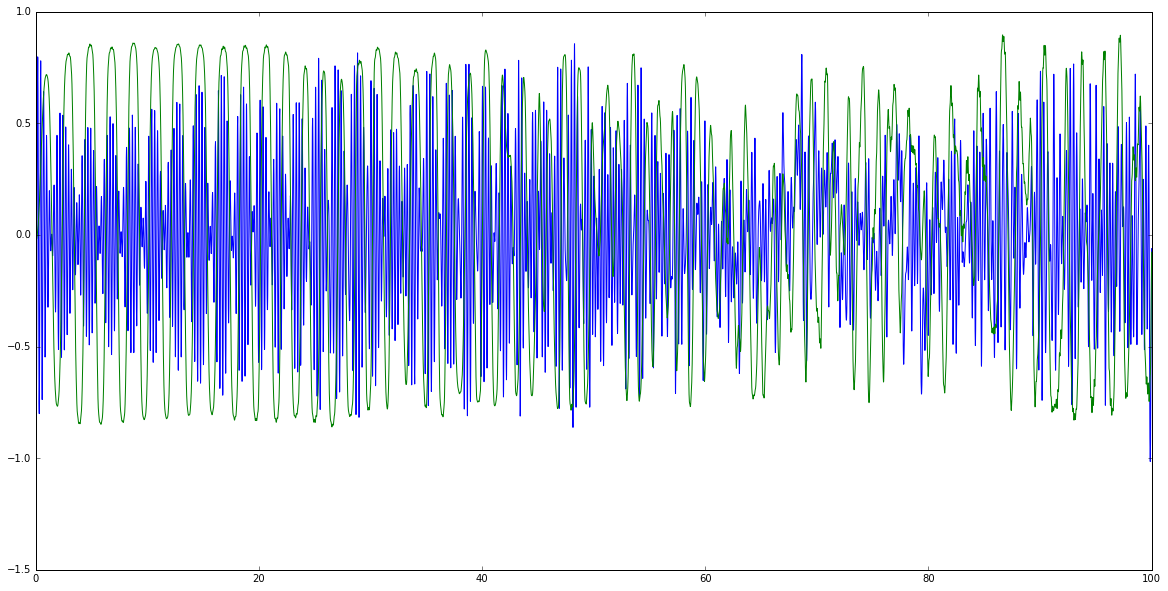

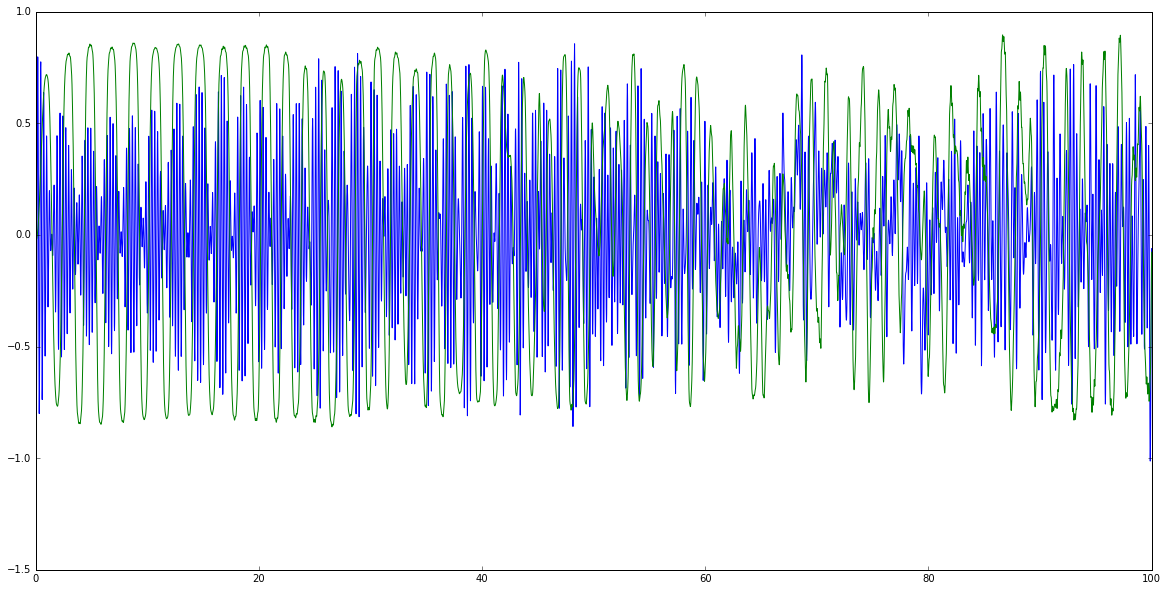

In [4]:
u0 = 1.00*np.load('data/cat-3-xi-zi-forbid-r10 total_time: 100.0, steps: 10000, size: 100_iter: 40_uks-Copy1.npy')
figure(figsize=(20,10))
plot(np.linspace(0,100,10000),u0[0])
plot(np.linspace(0,100,10000),u0[1])


new_u0_x = np.interp(np.linspace(100./14000,100,14000),np.linspace(100./10000,100,10000),u0[0],right=0,left=0)
new_u0_z = np.interp(np.linspace(100./14000,100,14000),np.linspace(100./10000,100,10000),u0[1],right=0,left=0)
figure(figsize=(20,10))
plot(np.linspace(0,100,14000),new_u0_x)
plot(np.linspace(0,100,14000),new_u0_z)

new_u0 = np.zeros([2,14000])
new_u0[0] = new_u0_x
new_u0[1] = new_u0_z

new_u0.shape

In [5]:
#new_u0 = np.load('data/cat-3-xi-zi-forbid-r10 total_time: 100.0, steps: 12000, size: 100_iter: 40_uks-Copy1.npy')

In [ ]:
uks,U_final = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence=convergence, draw = [states_draw_list,states_draw_names],  
                    state_transfer=state_transfer, 
                    show_plots =False, gate = "cat-3-xi-zi-forbid-r11", 
       unitary_error = 1e-4, method = 'Adam',switch = False, forbidden = forbidden,initial_guess = new_u0
                    ,penalty_coeffs = penalty_coeffs,multi_mode=multi_mode)

Using 7 Taylor terms and 4 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagators initialized.

In [ ]:
import numpy as np
np.linspace(50+50./2000,100,2000)

In [ ]:
#np.save('cat_2',uks)
np.save('cat_no_cav_x',uks)
a = np.load('final.npy')
b = np.load('target.npy')
a = a[:60] + (0+1j) * a[60:]
b = b[:60] + (0+1j) * b[60:]
v_sorted=sort_ev(v_c,dressed)

d= np.dot(np.transpose(v_sorted),a)

target = []
final = []
for ii in range(60):
    #print np.square(np.abs(np.dot(v_c[get_state_index(ii,dressed)],a))),np.square(cat[ii]),np.square(np.abs(d[ii]))
    target.append(np.square(cat[ii]))
    final.append(np.square(np.abs(d[ii])))

plt.figure(figsize=(15,7))
plt.subplot(121)

plt.plot(target[0:15])
plt.xlabel('Cavity mode #')
plt.ylabel('Population')
plt.title('Target Cavity Populations')
plt.subplot(122)
plt.plot(final[0:15])
plt.xlabel('Cavity mode #')
plt.ylabel('Population')
plt.title('Acheived Cavity Populations')


In [ ]:
from main_grape.Evolve import Evolve
Evolve(H0,Hops,total_time,steps,psi0,uks, U=U , draw = [states_draw_list,states_draw_names], Hnames = Hnames)


### 